In [1]:
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
from datetime import datetime
import mplfinance as mpf
from collections import defaultdict
from datetime import timedelta
from Backtest_source import *
import talib as ta
import shutil
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

pd.options.display.float_format = '{:.3f}'.format
np.set_printoptions(precision=3, suppress=True)

# Manual Extreme

In [16]:
class Strategy_Volatility_new(Strategy):
    def __init__(self, data_hr, strategy_list=['base']):
#         self.data_d = data_d
        self.data_hr = data_hr
#         self.run_time = run_time
#         self.name = name
        self.strategy_list = strategy_list
#         self.trading_fee = trading_fee
        self.list_variable = list(data_hr.columns)
#         self.run_time = datetime.now().strftime("%Y%m%d%H%M")

    def input_signal_pat(self, data):
        data.reset_index(drop=True, inplace=True)
        array_day = np.array([int(str(i)[:8]) for i in data['date']])
        array_time = np.array([int(str(i)[8:]) for i in data['date']])

        smoothing = 10
        extreme = 3
#        data.index = [datetime.strptime(str(i),'%Y%m%d%H%M') for i in data.date]
        data = add_extreme(data, smoothing, extreme)
#         print(data)
        index_pat = find_pattern(data)
#         print(index_pat)
        data.loc[index_pat, ['buy_signal']] = 1
        data['buy_signal'] = np.where(data['buy_signal'].shift(extreme+1)==1, 1, 0)
#         data['sell_signal'] = np.where(array_time == 1530, 1, 0)
        data['sell_signal'] = data['buy_signal'].shift(12)
        data['sell_signal'] = np.where((data['buy_signal']==1)|(array_time==1530), 1, 0)
        data['open_adj'] = data['open']
        data['close_adj'] = data['close']

        return data[['date','code_stock','open','high','low','close','open_adj','close_adj','buy_signal','sell_signal']].to_numpy().astype(np.int64)


    def output_status(self, data):
        array_status = np.where(np.roll(data[:,9], 1)==1, 0, np.where(data[:,8]==1, 1, np.nan))
        array_status_fill = fill_nan_with_last(array_status)
        return np.c_[data, array_status_fill.reshape(-1,1)]

    def cal_return(self, data):
        data[:,6] = np.where((data[:,10]==1)&(np.roll(data[:,10], 1)==0), data[:,6], data[:,2])
        data[:,7] = np.where((data[:,10]==1)&(np.roll(data[:,10], -1)==0), data[:,7], data[:,5])
        return data

      
    def calculate(self, run_time):
        data_raw = self.data_hr
        self.run_time = run_time
        for strategy in self.strategy_list:
            if 'total' in strategy:
                if 'pat' in strategy:
                    data_raw = self.input_signal_pat(data_raw)
#                     self.data_temp = data_raw
#                     print(data_raw)
                    data_raw = self.output_status(data_raw)
#                     self.data_temp2 = data_raw
#                     print(data_raw)
                    data_hr = self.cal_return(data_raw)
#                     print(data_hr)
        from_file_path = './Cal.ipynb' # 복사할 파일
        to_file_path = f'./result/{self.run_time}_code.ipynb' # 복사 위치 및 파일 이름 지정
        shutil.copyfile(from_file_path, to_file_path)
        return data_hr

In [20]:
date_start = datetime(2017,1,1,9)
date_end = datetime(2022,1,1,9)
stock_code = ['000220']
# stock_code = ['000220','000660']
case2 = Backtest_Stocks(date_start,date_end,stock_code,timeframe='minute5',option='pd')
case2.input_strategy(Strategy_Volatility_new,[f'total, pat'])
case2.trading_fee = 0.2
# name = 'dip'
case2.cal_strategy('pat')

df_all = case2.analyze_result_time1(name='pat',max_profit=True)
# summarize_result(df_all)

In [18]:
summarize_result(df_all)
# plot_trade(df_all[374])

'승률 : 15.40, 손익비 : 0.86  / 1266 (-0.22) / 195 (0.26) / 1071 (-0.30)'

In [3]:
def summarize_result(df_all):
    return_all = df_all[:,2]
    count = len(return_all)
    cnt_p = len(return_all[return_all>0])
    cnt_n = len(return_all[return_all<0])
    rtn_p = return_all[return_all>0].mean()
    rtn_n = return_all[return_all<0].mean()
    result = f'승률 : {cnt_p/count*100:.2f}, 손익비 : {-rtn_p/rtn_n:.2f}  / {count} ({return_all.mean()*100:.2f}) / {cnt_p} ({rtn_p*100:.2f}) / {cnt_n} ({rtn_n*100:.2f})'
    return result
def plot_trade(result_trade, save=False, timeframe='5m'):
    if timeframe == '5m':
        count_per_day = 79
        file_loc = './data/5m'
    elif timeframe == '1m':
        count_per_day = 399
        file_loc = './data/1m'
    
    code_coin = str(int(result_trade[3])).zfill(6)
    datetime_start = datetime.strptime(str(int(result_trade[0])),'%Y%m%d%H%M')
    date_start = datetime_start.replace(hour=9, minute=0)
    date_end = datetime_start.replace(hour=15, minute=30)
    datetime_end = datetime.strptime(str(int(result_trade[1])),'%Y%m%d%H%M')
    file_name = f'{file_loc}/A{code_coin}.csv'
    file = pd.read_csv(file_name, index_col=0)
    file.sort_values(by='date', ascending=True, inplace=True)
    file.reset_index(inplace=True,drop=True)
    file.index = list(file.index)
    first_index = file.index[(file['date']==int(result_trade[0]))][0]
    last_index = file.index[(file['date']==int(result_trade[1]))][0]
    file = file.iloc[first_index-count_per_day:last_index+count_per_day]
    file.index = [datetime.strptime(str(i),'%Y%m%d%H%M') for i in file.date]

    data = file[['open','high','low','close','volume']]
    file.loc[datetime_start, ['buy']] = result_trade[4]
    file.loc[datetime_end, ['sell']] = result_trade[5]
    buy_marker = mpf.make_addplot(file['buy'] , type='scatter', marker='>', markersize=10, panel=0)
    sell_marker = mpf.make_addplot(file['sell'] , type='scatter', marker='<', markersize=10, panel=0)
    rsi = ta.RSI(file['high']-file['close'], timeperiod=12)
    rsi_line = mpf.make_addplot(rsi)
    addplot = [buy_marker, sell_marker]
# ta.
    vlines = dict(vlines=[date_start,date_end],linewidths=(1,1), alpha=0.5)
    fb_color = 'b' if result_trade[4] < result_trade[5] else 'r'
    fb_range = dict(y1=result_trade[4], y2=result_trade[5], color=fb_color, alpha=0.2)

#     if save:
    savefile_name = f'./result/picture/{datetime.now().strftime("%Y%m%d%H%M")}_{code_coin}_{int(result_trade[0])}.png'
#         mpf.plot(data, type='candle', style='yahoo', addplot=addplot, title=f'{code_coin}', volume=True, vlines=dict(vlines=[date_start,date_end],linewidths=(1,1)),savefig=savefile_name, figscale=0.7, fill_between=dict(y1=result_trade[4], y2=result_trade[5]))
#     else:
#         mpf.plot(data, type='candle', style='yahoo', addplot=addplot, title=f'{code_coin}', volume=True, vlines=vlines, fill_between=fb_range)
    fig, axes = mpf.plot(data, type='candle', style='yahoo', addplot=addplot,  volume=True, vlines=vlines, fill_between=fb_range, returnfig=True)
#     axes[0].legend('aa')
    axes[0].set_title(f'{code_coin}')
    if save:
        fig.savefig(savefile_name)
    else:
        fig.show()
def add_extreme(data, smoothing, extreme):
    data['tuned_price'] = ta.EMA(data['high'], smoothing)
#     data['tuned_price'] = ta.EMA((data['high']+data['low']+data['close'])*data['volume'], smoothing)

    #     data['close'].rolling(window=smoothing).mean()
    n = extreme  # number of points to be checked before and after

    data['ex_min'] = data.iloc[argrelextrema(data.tuned_price.values, np.less_equal, order=n)[0]]['tuned_price']
    data['ex_max'] = data.iloc[argrelextrema(data.tuned_price.values, np.greater_equal, order=n)[0]]['tuned_price']
    data['ex'] = np.where(np.isnan(data['ex_min']), data['ex_max'], data['ex_min'])
    return data
def unique_seq(ar):
    _, ar_loc, ar_count = np.unique(ar, axis=0, return_inverse=True, return_counts=True)
    _, index = np.unique(ar_loc, return_index=True)
    return np.array([ar_count[ar_loc[i]] for i in np.sort(index)])
def find_pattern(data):  
    patterns = defaultdict(list)
    max_min = data['ex'].dropna()

    # Window range is 5 units
    for i in range(5, len(max_min)):  
        window = max_min.iloc[i-5:i]
        if np.busday_count(data.loc[window.index[0], 'date'], data.loc[window.index[-1], 'date']) >= 10000:
#             print(data.loc[window.index[0], 'date'], data.loc[window.index[-1], 'date'])
            #         if window.index[-1] - window.index[0] > 100: #100:      
            continue   
            
        a, b, c, d, e = window.iloc[0:5]
        
        # IHS
        cond_IHS1 = a < b
        cond_IHS2 = (c<a)&(c<e)&(c<d)&(e<d)
        cond_IHS3 = (abs(a-e)<=np.mean([a,e])*0.03)&(abs(b-d)<=np.mean([b,d])*0.03)
        if cond_IHS1&cond_IHS2&cond_IHS3:
#             patterns['IHS'].append((window.index[0], window.index[-1]))
            patterns['IHS'].append(window.index[-1])
        # IHS
#         if a<b and c<a and c<e and c<d and e<d and abs(b-d)<=np.mean([b,d])*0.02:
#             patterns['IHS'].append((window.index[0], window.index[-1]))
        
    return patterns['IHS']
def fill_nan_with_last(arr):
    prev = np.arange(len(arr))
    prev[np.isnan(arr)] = 0
    prev = np.maximum.accumulate(prev)
    return arr[prev]

# Sklearn clustering

In [3]:
def index_to_time(ind):
    return 900 + (ind//12)*100 + (ind%12)*5
def time_to_index(time):
    return ((time-900)//100)*12 + ((time%100)//5)

In [4]:
files = Path("./data/5m_modi/").rglob("*.csv")
files = [str(i)[-10:-4] for i in files if str(i)[-5] == '0' ]

In [11]:
#high, low, close, average, both, vwma, value/(volume+0.001), ma,
#volume_filter, value_filter, price_filter
#close_time, close_high, close_


n_clusters = 30
km = KMeans(n_clusters=n_clusters,random_state=1)
lr = LinearRegression()

stock_codes = files[:100]
return_all = []
# for i in range(1,7):
i=6
date_trade = datetime(2022, i, 1)
print(date_trade.strftime('%y%m%d'))
month_train = 3
month_test = 1
date_train_start = date_trade - relativedelta(months=month_train)
date_test_end = date_trade + relativedelta(months=month_test)
date_data_start = date_train_start - relativedelta(days=7)
date_data_end = date_test_end + relativedelta(days=7)
# time_buy = 1200

case_clu = Backtest_Stocks(date_data_start,date_data_end,stock_codes,timeframe='minute5',option='pd')
for i in tqdm(range(25,30)):
    return_base = [date_trade.strftime('%y%m%d')]
    time_buy = index_to_time(i)
    return_temp = pattern_result(case_clu.data_raw, date_trade, date_train_start, date_test_end, time_buy, 
                   price_method='close', train_method='daily_close')
    return_base[1:] = return_temp
    return_all.append(return_base)

# return_all = [pattern_result(case_clu.data_raw, date_trade, date_train_start, date_test_end, index_to_time(i), price_method='close', train_method='daily_close') for i in range(5,50)]


220601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  9.00s/it]


In [16]:
stock_codes = files[:100]
return_all = []
# for i in range(1,7):
i=6
date_trade = datetime(2022, i, 1)
print(date_trade.strftime('%y%m%d'))
month_train = 3
month_test = 1
date_train_start = date_trade - relativedelta(months=month_train)
date_test_end = date_trade + relativedelta(months=month_test)
date_data_start = date_train_start - relativedelta(days=7)
date_data_end = date_test_end + relativedelta(days=7)
# time_buy = 1200

case_clu = Backtest_Stocks(date_data_start,date_data_end,stock_codes,timeframe='minute5',option='pd')
for i in tqdm(range(25,30)):
    time_buy = index_to_time(i)
    return_base = [date_trade.strftime('%y%m%d'), time_buy]
    ar_train_input, ar_test_input, ar_train_result, ar_test_result = split_data(case_clu.data_raw, date_trade, date_train_start, date_test_end, time_buy, price_method='close', train_method='daily_close')
    model, label_arg_index = generate_model(ar_train_input, ar_train_result)
    return_temp = evaluate_model(model, label_arg_index, ar_test_input, ar_test_result)
    return_base[2:] = return_temp
    return_all.append(return_base)

# return_all = [pattern_result(case_clu.data_raw, date_trade, date_train_start, date_test_end, index_to_time(i), price_method='close', train_method='daily_close') for i in range(5,50)]

def split_data(data, date_trade, date_train_start, date_test_end, time_buy, price_method='close', train_method='daily_close'):
    array_date = np.array(data['date'])
    array_close = np.array(data['close'])
    array_code = np.array(data['code_stock']).astype(np.int32)
    array_day = np.array([int(str(i)[:8]) for i in array_date])
    array_time = np.array([int(str(i)[8:]) for i in array_date])

    if price_method == 'close':
        ar_price = np.array(case_clu.data_raw['close'])
    elif price_method == 'sma':
        ar_price = ta.SMA(case_clu.data_raw['close'], period)
    elif price_method == 'ema':
        ar_price = ta.EMA(case_clu.data_raw['close'], period)

    ind_time_train_end = time_to_index(time_buy)-1
    len_train = ind_time_train_end + 78

    ar_factor = np.array([1-np.sin(i/(len_train-2)*np.pi)/1.5 for i in range(len_train-1)])
    ar_price_acc = np.array([np.roll(ar_price, i+1) for i in range(len_train)]).T
    ar_price_acc = np.diff(ar_price_acc) / ar_price_acc[:,:-1] * 100 * ar_factor.reshape(1,-1)
    ar_price_norm = ar_price_acc / np.linalg.norm(ar_price_acc, axis=1).reshape(-1,1)
    ar_price_norm[np.isnan(ar_price_norm)] = 0  #전체 값이 0인 경우에는 0/0이므로 nan이 입력되며 이를 0으로 수정.

    day_train_start = int(date_train_start.strftime('%Y%m%d'))
    day_train_end = int(date_test_end.strftime('%Y%m%d'))
    day_train_base = int(date_trade.strftime('%Y%m%d'))
    
    cond_common_train = (array_time==time_buy)
    cond_common_test = (array_time==time_buy)&(array_close<=10000)
    
    ar_train_input = ar_price_norm[cond_common_train&(array_day <= day_train_base)&(array_day > day_train_start)]
    ar_test_input = ar_price_norm[cond_common_test&(array_day > day_train_base)&(array_day <= day_train_end)]

# high/low ratio                   
    if train_method == 'daily_close':
        ar_return = np.array([ar_price, np.roll(ar_price, ind_time_train_end+1-78)]).T
        ar_return = np.diff(ar_return) / ar_return[:,:-1] * 100
        ar_train_result = ar_return[cond_common_train&(array_day <= day_train_base)&(array_day > day_train_start)]
        ar_test_result = ar_return[cond_common_test&(array_day > day_train_base)&(array_day <= day_train_end)]

    return ar_train_input, ar_test_input, ar_train_result, ar_test_result

def generate_model(ar_train_input, ar_train_result):
    n_clusters = 30
    model = KMeans(n_clusters=n_clusters,random_state=1)
    model.fit(ar_train_input)
    count_label = max(km.labels_)+1
    label_train_result = np.array([ar_train_result[km.labels_==i].mean() for i in range(count_label)])  #label마다 train결과
    label_arg_index = label_train_result.argsort()[::-1]  # 내림차순으로 순서, 0 가장 우수
#     train_return_slope = lr.fit(np.arange(count_label).reshape(-1,1), label_train_result[label_arg_index].reshape(-1,1)).coef_[0][0]
    return model, label_arg_index

def evaluate_model(model, label_arg_index, ar_test_input, ar_test_result):
#    for model, label_arg_index in zip(models, label_arg_indexes):
    count_label = max(model.labels_)+1
    predict = model.predict(ar_test_input)
    label_test_result = np.array([ar_test_result[predict == i ].mean() for i in range(count_label)])  #label마다 test결과
    ar_up = np.concatenate([ar_test_result[predict==label_arg_index[i]] for i in range(int(count_label/10))]).flatten()
    ar_dn = np.concatenate([ar_test_result[predict==label_arg_index[-i-1]] for i in range(int(count_label/10))]).flatten()
    list_result_temp = [len(ar_up[ar_up>0])/len(ar_up), -ar_up[ar_up>0].mean()/ar_up[ar_up<0].mean(), len(ar_up), ar_up.mean(), len(ar_up[ar_up>0]), ar_up[ar_up>0].mean(), len(ar_up[ar_up<0]), ar_up[ar_up<0].mean(), len(ar_dn), ar_dn.mean(), len(ar_dn[ar_dn>0]), ar_dn[ar_dn>0].mean(), len(ar_dn[ar_dn<0]), ar_dn[ar_dn<0].mean()]
    return list_result_temp


220601


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]


NameError: name 'split_data' is not defined

In [14]:
a = [1,2]
b=[3]
a+b

[1, 2, 3]

In [12]:
pd.DataFrame(return_all).iloc[:,0:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,220601,1105,20220301,20220601,20220701,-0.003,-0.007,0.512,0.655,121,-0.208,62,1.325,53,-2.023
1,220601,1110,20220301,20220601,20220701,-0.003,-0.022,0.554,0.808,121,0.131,67,1.581,46,-1.957
2,220601,1115,20220301,20220601,20220701,-0.003,-0.020,0.414,1.677,70,0.229,29,2.313,37,-1.380
3,220601,1120,20220301,20220601,20220701,-0.003,-0.025,0.448,0.891,87,-0.197,39,1.355,46,-1.520
4,220601,1125,20220301,20220601,20220701,-0.005,-0.015,0.473,1.101,93,0.032,44,1.341,46,-1.218


In [6]:
pd.DataFrame(return_all).iloc[:,0:15]
# .to_csv('./pat_rtn.csv')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,220601,1105,20220301,20220601,20220701,-0.003,0.002,0.473,0.731,283,-0.173,134,1.280,126,-1.750
1,220601,1110,20220301,20220601,20220701,-0.003,-0.015,0.505,0.917,277,0.062,140,1.384,117,-1.510
2,220601,1115,20220301,20220601,20220701,-0.003,-0.010,0.438,1.416,153,0.133,67,1.705,78,-1.204
3,220601,1120,20220301,20220601,20220701,-0.003,-0.009,0.428,0.907,236,-0.178,101,1.252,122,-1.381
4,220601,1125,20220301,20220601,20220701,-0.005,-0.010,0.455,1.128,233,0.019,106,1.399,116,-1.240


In [10]:
def pattern_result(data, date_trade, date_train_start, date_test_end, time_buy, price_method='close', train_method='daily_close'):

    array_date = np.array(data['date'])
    array_close = np.array(data['close'])
    array_code = np.array(data['code_stock']).astype(np.int32)
    array_day = np.array([int(str(i)[:8]) for i in array_date])
    array_time = np.array([int(str(i)[8:]) for i in array_date])

    if price_method == 'close':
        ar_price = np.array(case_clu.data_raw['close'])

    ind_time_train_end = time_to_index(time_buy)-1
    len_train = ind_time_train_end + 78

    ar_factor = np.array([1-np.sin(i/(len_train-2)*np.pi)/1.5 for i in range(len_train-1)])
    ar_price_acc = np.array([np.roll(ar_price, i+1) for i in range(len_train)]).T
    ar_price_acc = np.diff(ar_price_acc) / ar_price_acc[:,:-1] * 100 * ar_factor.reshape(1,-1)
    ar_price_norm = ar_price_acc / np.linalg.norm(ar_price_acc, axis=1).reshape(-1,1)
    ar_price_norm[np.isnan(ar_price_norm)] = 0  #전체 값이 0인 경우에는 0/0이므로 nan이 입력되며 이를 0으로 수정.

    day_train_start = int(date_train_start.strftime('%Y%m%d'))
    day_train_end = int(date_test_end.strftime('%Y%m%d'))
    day_train_base = int(date_trade.strftime('%Y%m%d'))
    
    cond_common_train = (array_time==time_buy)
    cond_common_test = (array_time==time_buy)&(array_close<=10000)
    
    ar_train_input = ar_price_norm[cond_common_train&(array_day <= day_train_base)&(array_day > day_train_start)]
    ar_test_input = ar_price_norm[cond_common_test&(array_day > day_train_base)&(array_day <= day_train_end)]
                   
    if train_method == 'daily_close':
        ar_return = np.array([ar_price, np.roll(ar_price, ind_time_train_end+1-78)]).T
        ar_return = np.diff(ar_return) / ar_return[:,:-1] * 100
        ar_return_modi = np.where(ar_return > 0.4 , 1, 0)
#         ar_return = np.where(ar_return > 1, 2, np.where(ar_return > 0.4, 1, np.where(ar_return>0, 0, -1)  ) )
#         ar_train_result = ar_return[(array_time==time_buy)&(array_day <= day_train_base)&(array_day > day_train_start)]
        ar_train_result = ar_return_modi[cond_common_train&(array_day <= day_train_base)&(array_day > day_train_start)]
        ar_test_result = ar_return[cond_common_test&(array_day > day_train_base)&(array_day <= day_train_end)]
    elif train_method == 'slope':
        ar_price_slope = np.array([np.roll(ar_price, -i) for i in range(78-ind_time_train_end)]).T
        ar_price_slope = np.diff(ar_price_slope)/ar_price_slope[:,:-1]
        ar_slope = np.array([lr.fit(np.arange(78-ind_time_train_end-1).reshape(-1,1),i.reshape(-1,1)).coef_[0,0] for i in ar_price_slope]).reshape(-1,1)
        ar_train_result = ar_slope[(array_time==time_buy)&(array_day <= day_train_base)&(array_day > day_train_start)]
        ar_test_result = ar_slope[(array_time==time_buy)&(array_day > day_train_base)&(array_day <= day_train_end)]
    elif train_method == 'high_price':
        ar_price_high = np.array([np.roll(ar_price, -i) for i in range(78-ind_time_train_end)]).T
        ar_return_high = np.array([i.max()/i[0]*100 for i in ar_price_high]).reshape(-1,1)
        ar_train_result = ar_return_high[(array_time==time_buy)&(array_day <= day_train_base)&(array_day > day_train_start)]
        ar_test_result = ar_return_high[(array_time==time_buy)&(array_day > day_train_base)&(array_day <= day_train_end)]

    km.fit(ar_train_input)
    count_label = max(km.labels_)+1
    label_train_result = np.array([ar_train_result[km.labels_==i].mean() for i in range(count_label)])  #label마다 train결과
    _, count_train = np.unique(km.labels_, return_counts=True)
    label_arg_index = label_train_result.argsort()[::-1]  # 내림차순으로 순서

    predict = km.predict(ar_test_input)
    _, count_test = np.unique(predict, return_counts=True)
    label_test_result = np.array([ar_test_result[predict == i ].mean() for i in range(count_label)])  #label마다 test결과
    train_return_slope = lr.fit(np.arange(count_label).reshape(-1,1), label_train_result[label_arg_index].reshape(-1,1)).coef_[0][0]
    test_return_slope = lr.fit(np.arange(count_label).reshape(-1,1), label_test_result[label_arg_index].reshape(-1,1)).coef_[0][0]

    ar_up = np.concatenate([ar_test_result[predict==label_arg_index[i]] for i in range(int(count_label/10))]).flatten()
    ar_dn = np.concatenate([ar_test_result[predict==label_arg_index[-i-1]] for i in range(int(count_label/10))]).flatten()

    list_result_temp = [time_buy,day_train_start,day_train_base,day_train_end,train_return_slope,test_return_slope, len(ar_up[ar_up>0])/len(ar_up), -ar_up[ar_up>0].mean()/ar_up[ar_up<0].mean(), len(ar_up), ar_up.mean(), len(ar_up[ar_up>0]), ar_up[ar_up>0].mean(), len(ar_up[ar_up<0]), ar_up[ar_up<0].mean(), len(ar_dn), ar_dn.mean(), len(ar_dn[ar_dn>0]), ar_dn[ar_dn>0].mean(), len(ar_dn[ar_dn<0]), ar_dn[ar_dn<0].mean()]
    return list_result_temp


In [137]:
def reading_csv_int(file_name, datetime_start, datetime_end):
    file = pd.read_csv(file_name, index_col=0)
    file.sort_values(by='date', ascending=True, inplace=True)
    file = file[(file['date'] >= datetime_start) & (
                file['date'] <= datetime_end)]
    file['code_stock'] = str(file_name)[-10:-4]
#     if len(file)%79 == 0:
    return file[['date','time','open','high','low','close','volume','value','code_stock']]

In [5]:
date_start = datetime(2022,1,1)
date_end = datetime(2022,5,1)
# stock_code = ['000220']
stock_code = files[:10]
case_clu = Backtest_Stocks(date_start,date_end,stock_code,timeframe='minute5',option='pd')

In [6]:
array_date = np.array(case_clu.data_raw['date'])
array_code = np.array(case_clu.data_raw['code_stock']).astype(np.int32)

array_day = np.array([int(str(i)[:8]) for i in array_date])
array_time = np.array([int(str(i)[8:]) for i in array_date])

# array_code_day = np.array([array_code,array_day]).T
# array_code_day_count = unique_seq(array_code_day)

915


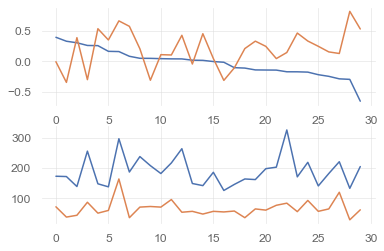

154 (0.05) / 65 (1.60) / 73 (-1.32)
212 (0.54) / 128 (1.47) / 68 (-1.08)
920


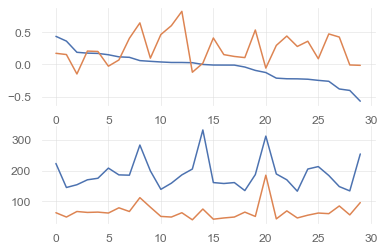

145 (0.03) / 61 (1.59) / 72 (-1.30)
161 (0.13) / 79 (1.30) / 66 (-1.25)
925


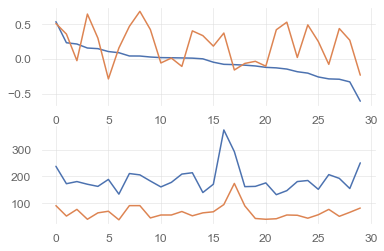

127 (0.29) / 67 (1.44) / 53 (-1.13)
173 (0.20) / 88 (1.17) / 65 (-1.06)
930


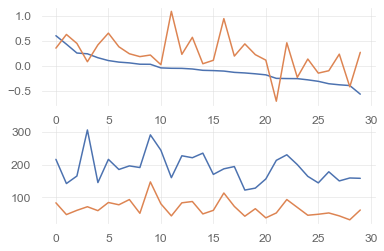

184 (0.46) / 94 (1.68) / 75 (-0.96)
122 (0.02) / 59 (1.12) / 49 (-1.31)
935


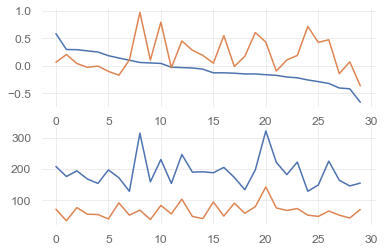

133 (0.10) / 63 (1.09) / 55 (-1.00)
179 (-0.07) / 85 (1.14) / 76 (-1.45)
940


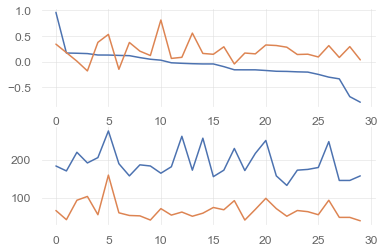

155 (0.16) / 74 (1.52) / 71 (-1.23)
155 (0.14) / 79 (1.36) / 58 (-1.48)
945


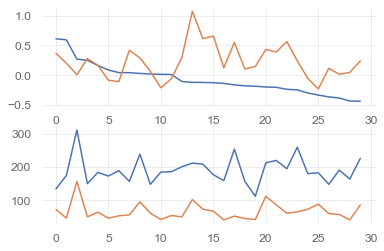

137 (0.18) / 59 (1.40) / 67 (-0.87)
153 (0.12) / 75 (1.32) / 63 (-1.29)
950


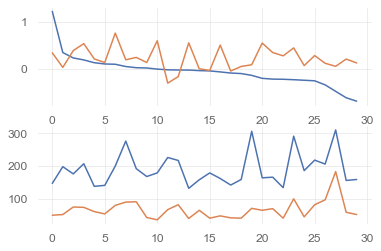

122 (0.24) / 58 (1.31) / 50 (-0.93)
172 (0.13) / 91 (1.11) / 66 (-1.20)
955


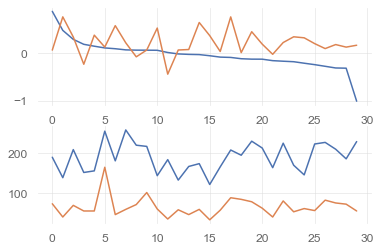

146 (0.41) / 66 (1.88) / 68 (-0.95)
224 (0.16) / 116 (1.20) / 91 (-1.14)
1000


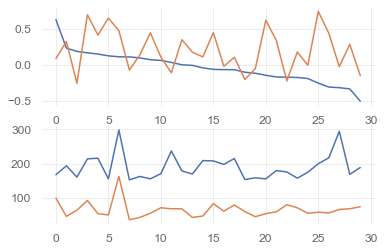

148 (0.08) / 69 (1.22) / 67 (-1.09)
231 (0.06) / 103 (1.20) / 105 (-1.03)
1005


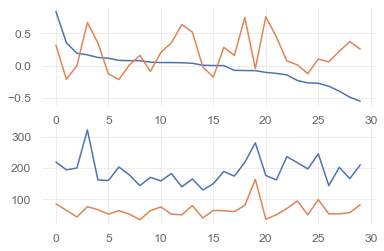

155 (0.02) / 75 (1.13) / 65 (-1.26)
164 (0.29) / 89 (1.18) / 64 (-0.91)
1010


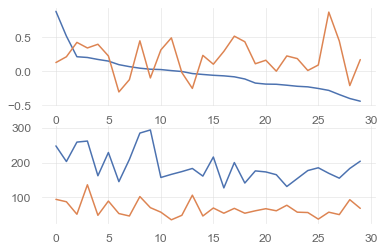

192 (0.29) / 99 (1.40) / 79 (-1.05)
158 (0.22) / 72 (1.58) / 69 (-1.14)
1015


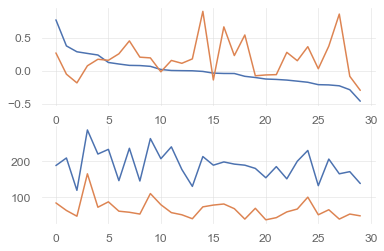

147 (-0.01) / 68 (0.96) / 69 (-0.96)
136 (0.14) / 62 (1.34) / 62 (-1.03)
1020


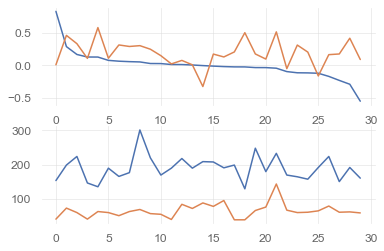

191 (0.30) / 96 (1.21) / 70 (-0.83)
178 (0.21) / 89 (1.04) / 65 (-0.85)
1025


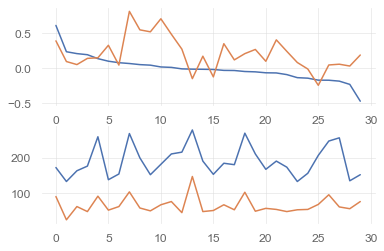

172 (0.18) / 84 (1.15) / 65 (-1.01)
184 (0.07) / 82 (1.14) / 85 (-0.94)
1030


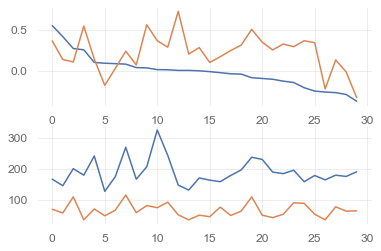

122 (0.20) / 66 (1.12) / 45 (-1.11)
222 (-0.14) / 103 (0.97) / 98 (-1.33)
1035


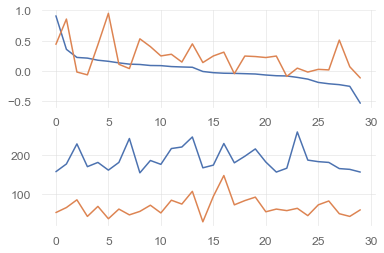

139 (0.34) / 79 (1.19) / 50 (-0.92)
134 (0.19) / 63 (1.17) / 57 (-0.85)
1040


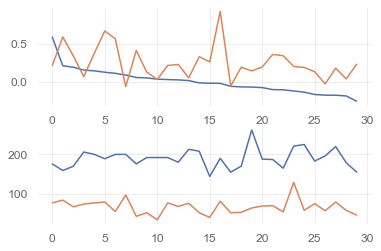

165 (0.35) / 85 (1.28) / 60 (-0.85)
188 (0.14) / 90 (1.05) / 72 (-0.95)
1045


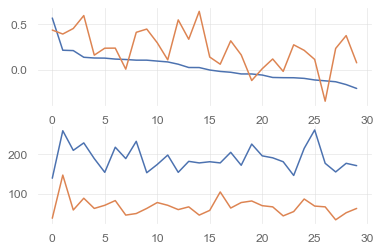

144 (0.43) / 68 (1.65) / 58 (-0.88)
218 (0.23) / 100 (1.20) / 93 (-0.74)
1050


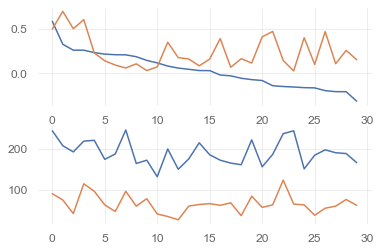

151 (0.55) / 84 (1.40) / 49 (-0.71)
229 (0.16) / 112 (1.16) / 92 (-1.00)
1055


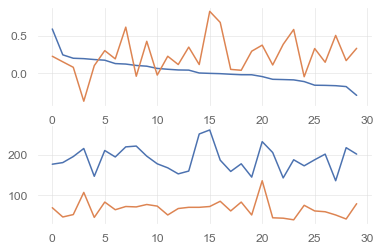

162 (0.15) / 83 (1.03) / 59 (-1.03)
168 (0.36) / 90 (1.21) / 56 (-0.86)
1100


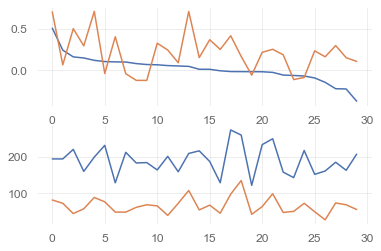

195 (0.38) / 98 (1.40) / 75 (-0.84)
204 (0.22) / 96 (1.05) / 75 (-0.75)
1105


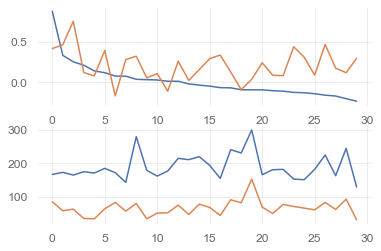

156 (0.63) / 85 (1.74) / 54 (-0.93)
209 (0.19) / 102 (0.99) / 84 (-0.72)
1110


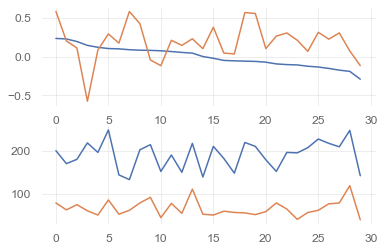

183 (0.31) / 84 (1.41) / 76 (-0.81)
251 (0.11) / 119 (0.98) / 105 (-0.86)
1115


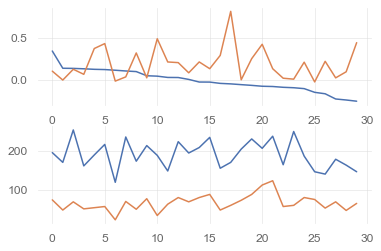

210 (0.07) / 102 (0.91) / 85 (-0.91)
166 (0.23) / 79 (1.06) / 60 (-0.75)
1120


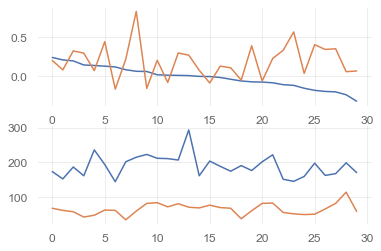

201 (0.20) / 102 (1.12) / 75 (-1.00)
191 (0.14) / 100 (0.87) / 74 (-0.81)
1125


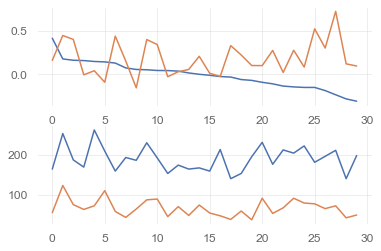

160 (0.34) / 83 (1.16) / 59 (-0.71)
169 (0.25) / 88 (1.13) / 64 (-0.91)
1130


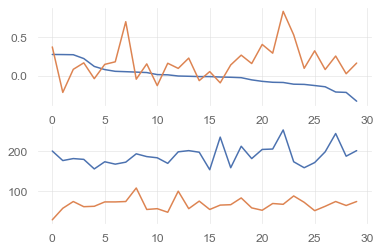

201 (0.11) / 89 (1.06) / 85 (-0.84)
162 (0.16) / 76 (1.08) / 66 (-0.85)
1135


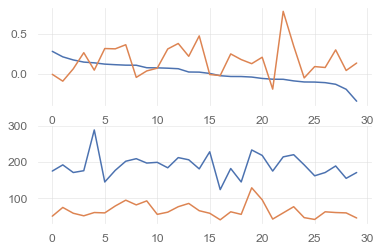

188 (-0.02) / 86 (0.79) / 76 (-0.95)
196 (0.15) / 95 (1.23) / 77 (-1.14)
1140


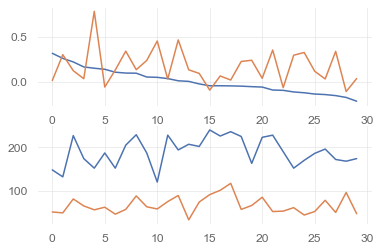

197 (0.14) / 91 (0.94) / 79 (-0.74)
249 (0.03) / 107 (0.96) / 110 (-0.87)
1145


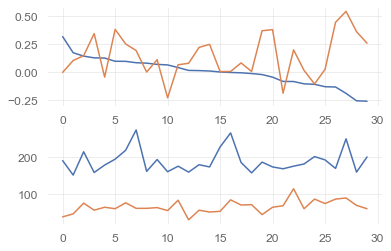

189 (0.09) / 91 (0.85) / 69 (-0.87)
219 (0.40) / 109 (1.34) / 73 (-0.79)
1150


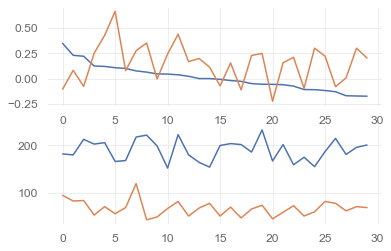

183 (-0.03) / 84 (0.80) / 79 (-0.91)
151 (0.18) / 83 (1.21) / 58 (-1.26)
1155


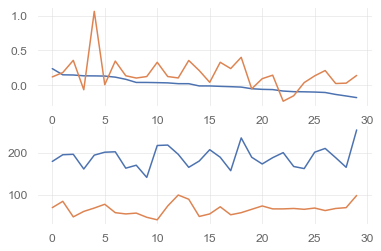

202 (0.21) / 109 (0.96) / 70 (-0.88)
213 (0.06) / 93 (0.97) / 95 (-0.81)
1200


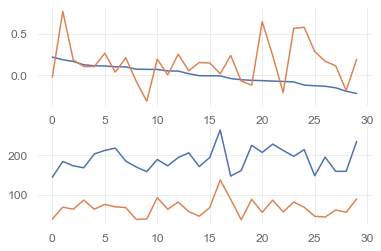

211 (0.34) / 101 (1.34) / 87 (-0.74)
140 (0.06) / 73 (0.84) / 57 (-0.93)
1205


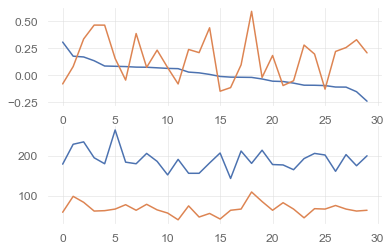

159 (0.13) / 75 (0.92) / 60 (-0.81)
196 (0.27) / 92 (1.43) / 76 (-1.04)
1210


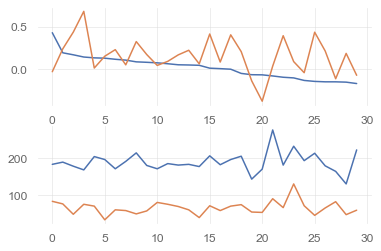

154 (0.27) / 78 (1.08) / 64 (-0.66)
245 (-0.02) / 109 (0.79) / 101 (-0.91)
1215


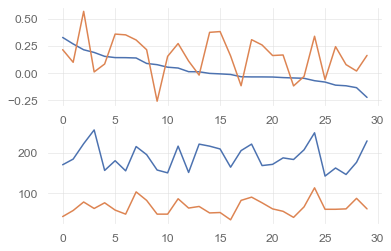

157 (0.37) / 75 (1.42) / 65 (-0.75)
218 (0.10) / 107 (0.99) / 73 (-1.16)
1220


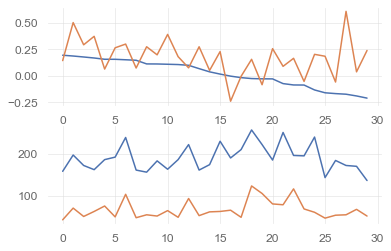

191 (0.34) / 102 (1.11) / 62 (-0.78)
178 (0.31) / 81 (1.35) / 74 (-0.73)
1225


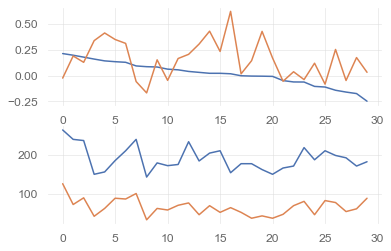

195 (0.11) / 96 (0.90) / 69 (-0.93)
233 (0.05) / 104 (1.04) / 101 (-0.95)
1230


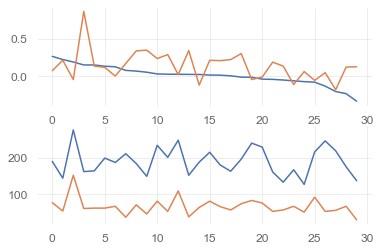

145 (0.07) / 66 (0.76) / 51 (-0.79)
233 (-0.07) / 101 (0.82) / 108 (-0.93)
1235


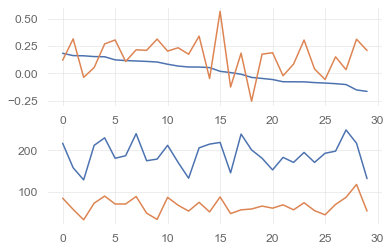

205 (0.16) / 100 (0.91) / 78 (-0.75)
188 (0.18) / 98 (0.82) / 71 (-0.66)
1240


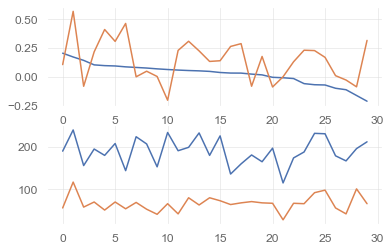

204 (0.23) / 100 (1.06) / 66 (-0.91)
213 (0.03) / 92 (1.15) / 100 (-1.00)
1245


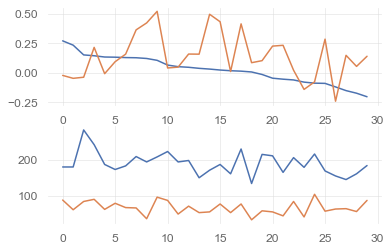

199 (-0.04) / 75 (0.75) / 87 (-0.73)
188 (0.12) / 92 (0.84) / 65 (-0.84)
1250


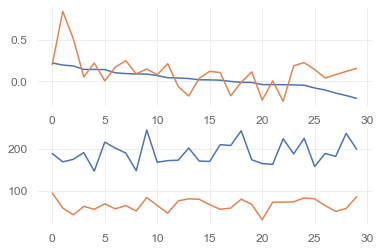

158 (0.59) / 78 (1.59) / 56 (-0.55)
204 (0.13) / 97 (0.78) / 82 (-0.61)
1255


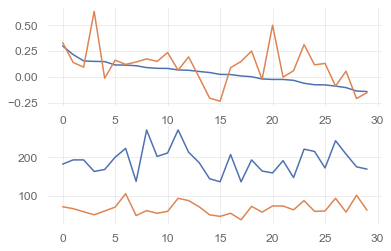

175 (0.16) / 79 (0.84) / 63 (-0.60)
189 (-0.11) / 84 (0.70) / 78 (-1.01)
1300


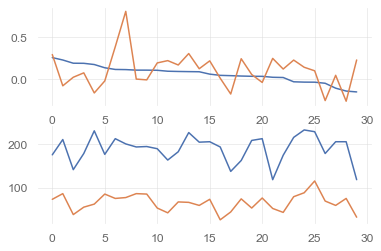

149 (0.06) / 68 (0.79) / 61 (-0.73)
243 (-0.05) / 104 (0.85) / 117 (-0.85)
1305


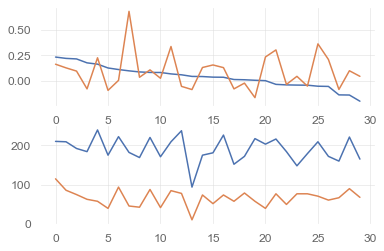

134 (0.12) / 64 (1.00) / 55 (-0.87)
178 (0.03) / 81 (1.18) / 76 (-1.20)
1310


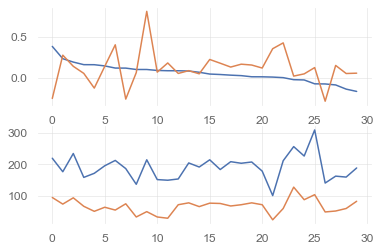

198 (0.15) / 83 (1.05) / 90 (-0.64)
181 (0.07) / 86 (0.76) / 80 (-0.66)
1315


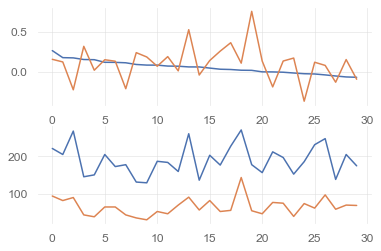

167 (0.06) / 68 (0.75) / 68 (-0.59)
183 (-0.01) / 84 (0.90) / 79 (-0.99)
1320


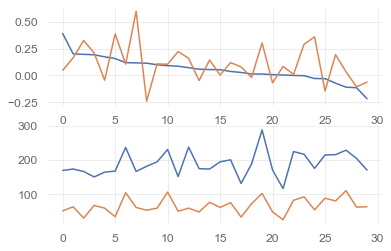

91 (0.19) / 46 (0.78) / 31 (-0.60)
217 (-0.06) / 99 (0.73) / 87 (-0.98)
1325


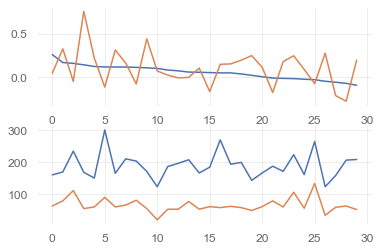

119 (0.08) / 55 (0.69) / 46 (-0.61)
255 (-0.14) / 96 (0.77) / 124 (-0.89)
1330


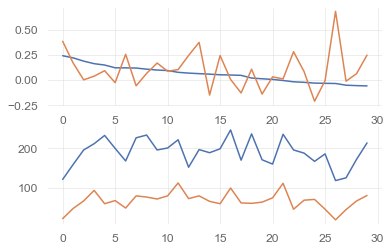

165 (0.10) / 78 (0.91) / 67 (-0.83)
187 (0.10) / 89 (0.75) / 65 (-0.74)
1335


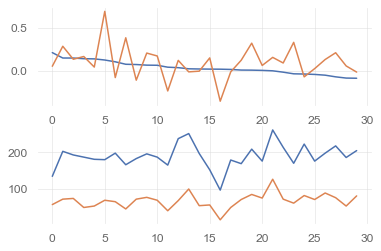

232 (0.16) / 99 (0.93) / 78 (-0.71)
190 (0.09) / 92 (0.79) / 74 (-0.75)
1340


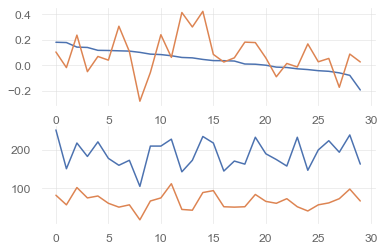

220 (0.10) / 101 (0.77) / 80 (-0.68)
220 (-0.06) / 82 (0.78) / 104 (-0.74)
1345


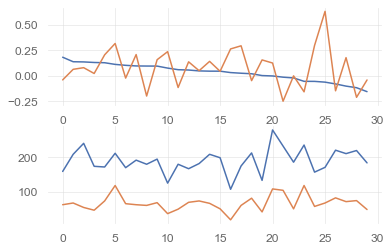

212 (0.04) / 86 (0.73) / 94 (-0.58)
238 (-0.06) / 100 (0.80) / 107 (-0.88)
1350


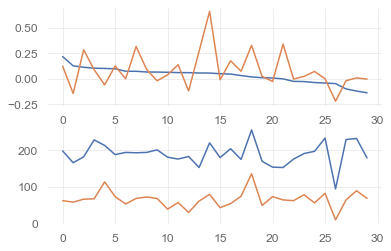

176 (0.15) / 66 (1.00) / 81 (-0.48)
197 (-0.01) / 95 (0.68) / 77 (-0.85)
1355


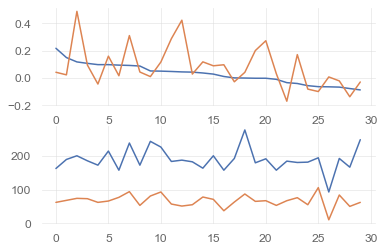

140 (0.06) / 63 (0.81) / 60 (-0.71)
223 (-0.08) / 89 (0.65) / 93 (-0.81)


In [45]:
ar_close = np.array(case_clu.data_raw['close'])
result_all = []
for i_time in range(3,60):
    try:
        buy_time = index_to_time(i_time)
        print(buy_time)
        ind = time_to_index(buy_time)-1
        length = ind+78

        ar_factor = np.array([1-np.sin(i/(length-2)*np.pi)/1.5 for i in range(length-1)])
        ar_close_acc = np.array([np.roll(ar_close, i+1) for i in range(length)]).T
        ar_close_acc = np.diff(ar_close_acc) / ar_close_acc[:,:-1] * 100 * ar_factor.reshape(1,-1)
        ar_close_norm = ar_close_acc / np.linalg.norm(ar_close_acc, axis=1).reshape(-1,1)
        ar_close_norm[np.isnan(ar_close_norm)] = 0  #전체 값이 0인 경우에는 0/0이므로 nan이 입력되며 이를 0으로 수정.

        day_train_start = 20220105
        day_train_end = 20220501
        day_train_base = 20220401
        ar_train_input = ar_close_norm[(array_time==buy_time)&(array_day <= day_train_base)&(array_day > day_train_start)]
        ar_test_input = ar_close_norm[(array_time==buy_time)&(array_day > day_train_base)&(array_day <= day_train_end)]

        ar_return = np.array([ar_close, np.roll(ar_close, ind+1-78)]).T
        ar_return = np.diff(ar_return) / ar_return[:,:-1] * 100

        ar_train_result = ar_return[(array_time==buy_time)&(array_day <= day_train_base)&(array_day > day_train_start)]
        ar_test_result = ar_return[(array_time==buy_time)&(array_day > day_train_base)&(array_day <= day_train_end)]

        n = 30
        km = KMeans(n_clusters=n,random_state=1)
        km.fit(ar_train_input)
        label_train_result = np.array([ar_train_result[km.labels_==i].mean() for i in range(n)])
        _, count_train = np.unique(km.labels_, return_counts=True)
        label_arg_index = label_train_result.argsort()[::-1]  # 내림차순으로 순서
        # plt.plot(range(n), label_train_result[label_arg_index])

        predict = km.predict(ar_test_input)
        _, count_test = np.unique(predict, return_counts=True)
        label_test_result = np.array([ar_test_result[predict == i ].mean() for i in range(n)])
        # plt.plot(range(n), label_test_result[label_arg_index])
        # plt.show()
        mean_gap=2
        fig, ax = plt.subplots(2,1)
        ax[0].plot(range(n), label_train_result[label_arg_index])
        ax[0].plot(range(n), label_test_result[label_arg_index])
        # ax[0].plot(range(mean_gap,n-mean_gap), [label_test_result[label_arg_index][i:i+2*mean_gap+1].mean() for I in range(n-2*mean_gap)])
        ax[1].plot(count_train)
        ax[1].plot(count_test)
        plt.show()

        ar_up = np.concatenate([ar_test_result[predict==label_arg_index[i]] for i in range(int(n/10))]).flatten()
        ar_dn = np.concatenate([ar_test_result[predict==label_arg_index[-i-1]] for i in range(int(n/10))]).flatten()
        print(f'{len(ar_up)} ({ar_up.mean():.2f}) / {len(ar_up[ar_up>0])} ({ar_up[ar_up>0].mean():.2f}) / {len(ar_up[ar_up<0])} ({ar_up[ar_up<0].mean():.2f})')
        print(f'{len(ar_dn)} ({ar_dn.mean():.2f}) / {len(ar_dn[ar_dn>0])} ({ar_dn[ar_dn>0].mean():.2f}) / {len(ar_dn[ar_dn<0])} ({ar_dn[ar_dn<0].mean():.2f})')
        list_result_temp = [buy_time, len(ar_up), ar_up.mean(), len(ar_up[ar_up>0]), ar_up[ar_up>0].mean(), len(ar_up[ar_up<0]), ar_up[ar_up<0].mean(), len(ar_dn), ar_dn.mean(), len(ar_dn[ar_dn>0]), ar_dn[ar_dn>0].mean(), len(ar_dn[ar_dn<0]), ar_dn[ar_dn<0].mean()]
        result_all.append(list_result_temp)
    except:
        continue

In [46]:
pd.DataFrame(result_all)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,915,154,0.050,65,1.598,73,-1.317,212,0.539,128,1.468,68,-1.083
1,920,145,0.027,61,1.595,72,-1.296,161,0.126,79,1.299,66,-1.247
2,925,127,0.288,67,1.438,53,-1.129,173,0.197,88,1.171,65,-1.062
3,930,184,0.465,94,1.679,75,-0.965,122,0.017,59,1.125,49,-1.313
4,935,133,0.101,63,1.088,55,-1.002,179,-0.074,85,1.142,76,-1.451
5,940,155,0.161,74,1.516,71,-1.229,155,0.139,79,1.357,58,-1.477
6,945,137,0.181,59,1.405,67,-0.867,153,0.116,75,1.321,63,-1.291
7,950,122,0.241,58,1.311,50,-0.933,172,0.126,91,1.110,66,-1.201
8,955,146,0.408,66,1.883,68,-0.952,224,0.159,116,1.202,91,-1.141
9,1000,148,0.075,69,1.219,67,-1.089,231,0.064,103,1.196,105,-1.033


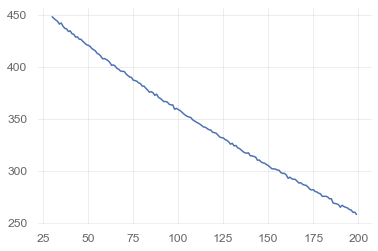

In [7]:
ar_close = np.array(case_clu.data_raw['close'])
buy_time = 1300
ind = time_to_index(buy_time)-1
length = ind+78

ar_factor = np.array([1-np.sin(i/(length-2)*np.pi)/1.5 for i in range(length-1)])
ar_close_acc = np.array([np.roll(ar_close, i+1) for i in range(length)]).T
ar_close_acc = np.diff(ar_close_acc) / ar_close_acc[:,:-1] * 100 * ar_factor.reshape(1,-1)
ar_close_norm = ar_close_acc / np.linalg.norm(ar_close_acc, axis=1).reshape(-1,1)
ar_close_norm[np.isnan(ar_close_norm)] = 0  #전체 값이 0인 경우에는 0/0이므로 nan이 입력되며 이를 0으로 수정.

day_train_start = 20220105
day_train_end = 20220501
day_train_base = 20220401
ar_train_input = ar_close_norm[(array_time==buy_time)&(array_day <= day_train_base)&(array_day > day_train_start)]
ar_test_input = ar_close_norm[(array_time==buy_time)&(array_day > day_train_base)&(array_day <= day_train_end)]

ar_return = np.array([ar_close, np.roll(ar_close, -36)]).T
ar_return = np.diff(ar_return) / ar_return[:,:-1] * 100

ar_train_result = ar_return[(array_time==buy_time)&(array_day <= day_train_base)&(array_day > day_train_start)]
ar_test_result = ar_return[(array_time==buy_time)&(array_day > day_train_base)&(array_day <= day_train_end)]

# 적정 cluster 숫자 찾기.
inertia = []
for i in range(30,200):
    km = KMeans(n_clusters=i)
    km.fit(ar_train_input)
    inertia.append(km.inertia_)
plt.plot(range(30,200), inertia)
plt.show()

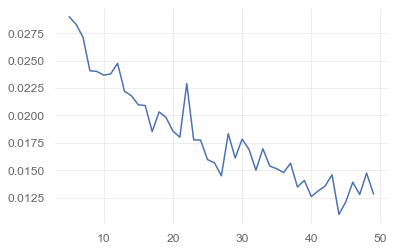

In [12]:
from sklearn.metrics import silhouette_samples, silhouette_score
score = []
for i in range(5,50):
    km = KMeans(n_clusters=i)
    km.fit(ar_train_input)
    average_score = silhouette_score(ar_train_input, km.labels_)
    score.append(average_score)
plt.plot(range(5,50), score)


0.8051652496411437


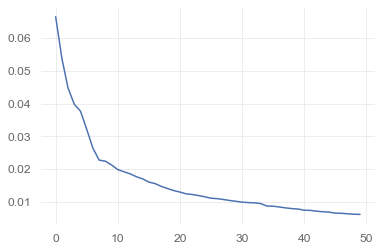

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(ar_train_input)
data_pca = pca.transform(ar_train_input)
print(np.sum(pca.explained_variance_ratio_))
plt.plot(pca.explained_variance_ratio_)


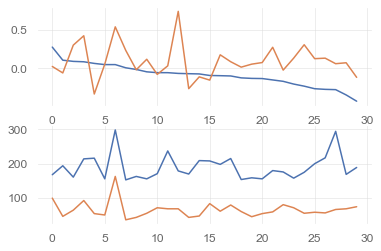

In [25]:
n = 30
km = KMeans(n_clusters=n,random_state=1)
km.fit(ar_train_input)
label_train_result = np.array([ar_train_result[km.labels_==i].mean() for i in range(n)])
_, count_train = np.unique(km.labels_, return_counts=True)
label_arg_index = label_train_result.argsort()[::-1]  # 내림차순으로 순서
# plt.plot(range(n), label_train_result[label_arg_index])

predict = km.predict(ar_test_input)
_, count_test = np.unique(predict, return_counts=True)
label_test_result = np.array([ar_test_result[predict == i ].mean() for i in range(n)])
# plt.plot(range(n), label_test_result[label_arg_index])
# plt.show()
mean_gap=2
fig, ax = plt.subplots(2,1)
ax[0].plot(range(n), label_train_result[label_arg_index])
ax[0].plot(range(n), label_test_result[label_arg_index])
# ax[0].plot(range(mean_gap,n-mean_gap), [label_test_result[label_arg_index][i:i+2*mean_gap+1].mean() for I in range(n-2*mean_gap)])
ax[1].plot(count_train)
ax[1].plot(count_test)
plt.show()



In [26]:
ar_up = np.concatenate([ar_test_result[predict==label_arg_index[i]] for i in range(int(n/10))]).flatten()
ar_dn = np.concatenate([ar_test_result[predict==label_arg_index[-i-1]] for i in range(int(n/10))]).flatten()
print(f'{len(ar_up)} ({ar_up.mean():.2f}) / {len(ar_up[ar_up>0])} ({ar_up[ar_up>0].mean():.2f}) / {len(ar_up[ar_up<0])} ({ar_up[ar_up<0].mean():.2f})')
print(f'{len(ar_dn)} ({ar_dn.mean():.2f}) / {len(ar_dn[ar_dn>0])} ({ar_dn[ar_dn>0].mean():.2f}) / {len(ar_dn[ar_dn<0])} ({ar_dn[ar_dn<0].mean():.2f})')


166 (0.10) / 79 (0.98) / 70 (-0.87)
203 (0.02) / 88 (0.90) / 91 (-0.82)


In [73]:
label_train_result

array([ 0.071, -0.12 , -0.186, -0.241,  0.054,  0.102,  0.003, -0.04 ,
       -0.181, -0.298, -0.169, -0.081, -0.083,  0.459, -0.122,  0.062,
       -0.09 , -0.256, -0.033,  0.115,  0.01 , -0.138, -0.295, -0.252,
        0.078, -0.199, -0.098,  0.1  , -0.241, -0.102])

In [71]:
a = np.array([3,2,1,-1,1.5])
a.argsort()

array([3, 2, 4, 1, 0], dtype=int64)

In [75]:
ar_test_result.flatten().argsort()

array([2500, 2252, 2266, ..., 3316,  717, 2575], dtype=int64)

In [80]:
ar_code2 = array_code[(array_time==1000)&(array_day > day_train_base)&(array_day <= day_train_end)]
ar_code3 = ar_code2[ar_test_result.flatten().argsort()[::-1]][:10]
ar_time2 = array_day[(array_time==1000)&(array_day > day_train_base)&(array_day <= day_train_end)]
ar_time3 = ar_time2[ar_test_result.flatten().argsort()[::-1]][:10]
ar_rlt = ar_test_result[ar_test_result.flatten().argsort()[::-1]][:10]

In [81]:
print(ar_code3)
print(ar_time3)
print(ar_rlt)

[2920  760 3800 4450  590 2360  440 4090 1250  230]
[20220429 20220429 20220429 20220429 20220429 20220429 20220412 20220429
 20220411 20220422]
[[8222.476]
 [1020.879]
 [ 201.703]
 [  69.128]
 [  65.689]
 [  32.751]
 [  23.09 ]
 [  20.859]
 [  20.139]
 [  18.756]]


In [83]:
d = case_clu.data_raw
d[(d.date>=202204290000)&(d.date<202204300000)&(d.code_stock=='002920')]

,date,time,open,high,low,close,volume,code_stock
7710,202204290905,905,3040,3040,3035,3035,4733,002920
7709,202204290915,915,3040,3060,3040,3060,1277,002920
7708,202204290925,925,3060,3060,3050,3050,12,002920
7707,202204290930,930,3060,3060,3055,3055,57,002920
7706,202204290935,935,3065,3070,3065,3065,121,002920
7705,202204290940,940,3055,3055,3055,3055,20,002920
7704,202204290945,945,3060,3060,3060,3060,1,002920
7703,202204290950,950,3060,3065,3060,3065,409,002920
7702,202204290955,955,3065,3065,3065,3065,116,002920
7701,202204291000,1000,3065,3070,3065,3070,607,002920


In [98]:
def intervaled_x(ar, sizes):
    out = ar.copy()
    out = np.array([np.roll(out, i+1) for i in range(5)]).T
#     print(out)
    sizes = np.insert(sizes, 0, 0)
    idx = sizes.cumsum()[:-1]
#     print(idx)
    return out[idx]

In [29]:
def intervaled_first(ar, sizes):
    out = ar.copy()
    sizes = np.insert(sizes, 0, 0)
    idx = sizes.cumsum()
    out = [ np.ones(sizes[i+1])*out[idx[i]] for i in range(len(sizes)-1)]
    return np.concatenate(out)
array_open_d = intervaled_first(array_open, array_code_day_count)
array_open_d

array([6358., 6358., 6358., ..., 7890., 7890., 7890.])

In [73]:
code = '000220'
data = pd.read_csv(f'./data/1m/A{code}.csv',index_col=0)
data.index = [datetime.strptime(str(i), '%Y%m%d%H%M') for i in data['date']]
data = data[['open','high','low','close']]

data.index.name='timestamp'
data.sort_values(by='timestamp',inplace=True)
data = find_extreme(data, 20, 5)
find_pattern(data['ex'].dropna())

[Timestamp('2020-11-18 10:12:00'),
 Timestamp('2020-11-20 11:02:00'),
 Timestamp('2021-01-08 11:31:00'),
 Timestamp('2021-02-05 10:49:00'),
 Timestamp('2021-02-18 14:29:00'),
 Timestamp('2021-02-25 10:42:00'),
 Timestamp('2021-03-30 11:55:00'),
 Timestamp('2021-03-30 12:47:00'),
 Timestamp('2021-04-01 14:14:00'),
 Timestamp('2021-04-07 09:33:00'),
 Timestamp('2021-04-07 13:33:00'),
 Timestamp('2021-04-13 09:14:00'),
 Timestamp('2021-04-14 11:59:00'),
 Timestamp('2021-04-14 12:55:00'),
 Timestamp('2021-04-15 15:00:00'),
 Timestamp('2021-05-18 09:31:00'),
 Timestamp('2021-05-20 13:50:00'),
 Timestamp('2021-05-24 14:46:00'),
 Timestamp('2021-05-25 14:23:00'),
 Timestamp('2021-05-26 10:23:00'),
 Timestamp('2021-05-31 14:23:00'),
 Timestamp('2021-06-10 10:07:00'),
 Timestamp('2021-06-15 10:35:00'),
 Timestamp('2021-06-18 09:52:00'),
 Timestamp('2021-06-21 10:56:00'),
 Timestamp('2021-06-29 09:03:00'),
 Timestamp('2021-06-30 11:58:00'),
 Timestamp('2021-07-13 11:05:00'),
 Timestamp('2021-07-

In [72]:
data

,open,high,low,close,tuned_price,ex_min,ex_max,ex
timestamp,,,,,,,,
2020-11-06 09:01:00,7578,7578,7526,7526,NaN,NaN,NaN,NaN
2020-11-06 09:02:00,7500,7526,7500,7526,NaN,NaN,NaN,NaN
2020-11-06 09:03:00,7526,7526,7474,7474,NaN,NaN,NaN,NaN
2020-11-06 09:04:00,7474,7474,7422,7422,NaN,NaN,NaN,NaN
2020-11-06 09:05:00,7422,7422,7396,7396,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-11-11 15:16:00,6190,6190,6190,6190,6166.500,NaN,6166.500,6166.500
2022-11-11 15:17:00,6160,6160,6150,6150,6165.500,NaN,NaN,NaN
2022-11-11 15:19:00,6180,6180,6160,6160,6165.000,6165.000,NaN,6165.000
